In [1]:
import numpy as np
from scipy import stats
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
# mpl.rcParams['figure.dpi'] = 600


# def Func

In [2]:
def input_prep(df_boundary):
    df_boundary['bernoulli_gmean'] = np.sqrt(df_boundary['gmean mean'] - (df_boundary['gmean mean']*df_boundary['gmean mean']))
    df_boundary['bernoulli_tap_water'] = np.sqrt(df_boundary['treated tap water mean'] - (df_boundary['treated tap water mean'])**2)
    df_boundary['bernoulli_water_loc'] = np.sqrt(df_boundary['water location within mean'] - (df_boundary['water location within mean'])**2)
    df_boundary['bernoulli_housing'] = np.sqrt(df_boundary['housing mean'] - (df_boundary['housing mean'])**2)
    df_boundary['bernoulli_sanitation'] = np.sqrt(df_boundary['sanitation mean'] - (df_boundary['sanitation mean'])**2)
    df_boundary['bernoulli_electricity'] = np.sqrt(df_boundary['electricity mean'] - (df_boundary['electricity mean'])**2)

    df_boundary = df_boundary.rename(columns = {'treated tap water mean':'tap_water_mean'
                                            , 'housing mean':'housing_mean', 'water location within mean':'water_loc_mean'
                                            , 'electricity mean':'electricity_mean', 'sanitation mean':'sanitation_mean'
                                            , 'treated tap water std':'tap_water_std', 'housing std':'housing_std'
                                            , 'water location within std':'water_loc_std'
                                            , 'electricity std':'electricity_std', 'sanitation std':'sanitation_std', 'gmean mean':'gmean_mean', 'gmean std': 'gmean_std'})
    return df_boundary

def b_fit(df_boundary, field='tap_water', ols=False):
    y=df_boundary[field+'_std']
    y=y.tolist()
    x=df_boundary['bernoulli_'+field] 
    x=x.tolist()

    if ols:
        model_ols = smf.ols(field+'_std ~ bernoulli_'+field+'- 1', data = df_boundary).fit(cov_type = 'HC3')
    else:
        model_ols = sm.WLS(y, x, df_boundary['population']).fit() 

    bp_test = het_breuschpagan(model_ols.resid, model_ols.model.exog)
    b = pd.DataFrame()
    # b['ptest'] = bp_test
    b['x'] = np.arange(0, 1.01, 0.0001).tolist()
    b['b0'] = 0*np.sqrt(b['x'] - b['x']**2)
    b['bestfit'] = model_ols.params[0]  *np.sqrt(b['x'] - b['x']**2)
    b['b1'] = np.sqrt(b['x'] - b['x']**2)
    b['linear'] = b['x']
    b['bestfitplot'] = model_ols.params[0]  *b['x']

    return b

def res_plot(df_boundary, metric, c='k', ax='ax1'):
    sns.residplot(x=df_boundary['bernoulli_'+metric] , y=df_boundary[metric+'_std'], color=c, ax=ax)

def white_reg_plot(df_boundary, b, metric, c='k', cfit='r', ax='ax1'):
    ax.scatter(df_boundary['bernoulli_'+metric] , df_boundary[metric+'_std'] , s = df_boundary['population']/15000, facecolors='none', edgecolors=c, linewidths = 0.5)
    ax.plot(b[b['x'] <= 0.5]['x'], b[b['x'] <= 0.5]['linear'], 'black', 
            # label = 'boundary line', 
            linewidth = 0.5)
    ax.plot(b[b['x'] <= 0.5]['x'], b[b['x'] <= 0.5]['bestfitplot'], color=cfit, ls='-',
            #  label = 'best fit', 
             linewidth = 0.5)

def het_plot(df_boundary, b, metric, c='k', cfit='r', ax='ax1'):
    ax.scatter(df_boundary[metric+'_mean'], df_boundary[metric+'_std'], s = df_boundary['population']/15000, facecolors='none'
                , edgecolors=c, label = metric, linewidths = 0.5)
    ax.plot(b['x'], b['b1'], 'black',
            #  label = 'boundary line', 
             linewidth = 0.5)
    ax.plot(b['x'], b['bestfit'], color=cfit, ls='--', 
            # label = 'best fit',
              linewidth = 0.5)
    ax.set_aspect('equal')
    

def proj_material(wards, mat_intensity, sensitivity='Average'):
    mat = mat_intensity[mat_intensity['Sensitivity'] == sensitivity].copy()
    mat = mat[['Material', 'Mass per HH', 'EE per HH', 'CO2 per HH']]
    mat = mat.reset_index()
    mat.drop(columns = 'index', inplace = True)    

    wards = pd.DataFrame(wards.sum()).T
    wards['housing gap'] = wards['households'] - wards['housing']
    # wards['housing'] = wards['housing']/wards['households']
    # wards['sanitation'] = wards['sanitation']/wards['households']
    # wards['tap_water'] = wards['tap_water']/wards['households']
    # wards['water_loc'] = wards['water_loc']/wards['households']
    # wards['electricity'] = wards['electricity']/wards['households']
    # wards['gmean'] = np.power(wards.iloc[:,0:5].prod(axis = 1), 1.0/5)
    # wards['amean'] = wards.iloc[:,0:5].mean(axis = 1)

    # wards['housing'] = 1.0
    # wards['gmean_2'] = np.power(wards.iloc[:,0:5].prod(axis = 1), 1.0/5)
    # wards['amean_2'] = wards.iloc[:,0:5].mean(axis = 1)
    col1=['Concrete mass','Brick mass','Steel mass','Clay mass','Bitumen mass']
    col2=['Concrete EE','Brick EE','Steel EE','Clay EE','Bitumen EE']
    col3=['Concrete CO2','Brick CO2','Steel CO2','Clay CO2','Bitumen CO2']

    wards['Total mass'] = wards['housing gap']*mat.iloc[0,1]
    wards['Concrete mass'] = wards['housing gap']*mat.iloc[1,1]
    wards['Brick mass'] = wards['housing gap']*mat.iloc[2,1]
    wards['Steel mass'] = wards['housing gap']*mat.iloc[3,1]
    wards['Clay mass'] = wards['housing gap']*mat.iloc[4,1]
    wards['Bitumen mass'] = wards['housing gap']*mat.iloc[5,1]

    wards['Total EE'] = wards['housing gap']*mat.iloc[0,2]
    wards['Concrete EE'] = wards['housing gap']*mat.iloc[1,2]
    wards['Brick EE'] = wards['housing gap']*mat.iloc[2,2]
    wards['Steel EE'] = wards['housing gap']*mat.iloc[3,2]
    wards['Clay EE'] = wards['housing gap']*mat.iloc[4,2]
    wards['Bitumen EE'] = wards['housing gap']*mat.iloc[5,2]

    wards['Total CO2'] = wards['housing gap']*mat.iloc[0,3]
    wards['Concrete CO2'] = wards['housing gap']*mat.iloc[1,3]
    wards['Brick CO2'] = wards['housing gap']*mat.iloc[2,3]
    wards['Steel CO2'] = wards['housing gap']*mat.iloc[3,3]
    wards['Clay CO2'] = wards['housing gap']*mat.iloc[4,3]
    wards['Bitumen CO2'] = wards['housing gap']*mat.iloc[5,3]

    return wards, wards.loc[:,col1], wards.loc[:,col2], wards.loc[:,col3]

def sdi_proj(wards2, mat_intensity, sensitivity='Average', boundary='none'):
    mat = mat_intensity[mat_intensity['Sensitivity'] == sensitivity].copy()
    mat = mat[['Material', 'Mass per HH', 'EE per HH', 'CO2 per HH']]
    mat = mat.reset_index()
    mat.drop(columns = 'index', inplace = True)    

    if boundary!='none':
        wards2 = wards2.groupby(boundary, as_index=False).sum()
        
    wards2['housing gap'] = wards2['households'] - wards2['housing']
    wards2['housing'] = wards2['housing']/wards2['households']
    wards2['sanitation'] = wards2['sanitation']/wards2['households']
    wards2['tap_water'] = wards2['tap_water']/wards2['households']
    wards2['water_loc'] = wards2['water_loc']/wards2['households']
    wards2['electricity'] = wards2['electricity']/wards2['households']

    cols = ['housing', 'sanitation', 'tap_water', 'water_loc', 'electricity']
    wards2['gmean'] = np.power(wards2.loc[:,cols].prod(axis = 1), 1.0/5)
    wards2['amean'] = wards2.loc[:,cols].mean(axis = 1)
    wards2['housing'] = 1.0
    wards2['gmean_2'] = np.power(wards2.loc[:,cols].prod(axis = 1), 1.0/5)
    wards2['amean_2'] = wards2.loc[:,cols].mean(axis = 1)
    wards2['gmean diff'] = wards2['gmean_2'] - wards2['gmean']
    wards2['gmean diff_2'] = (wards2['gmean_2'] - wards2['gmean'])/wards2['gmean']*100
    wards2['amean diff'] = wards2['amean_2'] - wards2['amean']

    wards2['Total mass'] = wards2['housing gap']*mat.iloc[0,1]
    # wards['Concrete mass'] = wards['housing gap']*mat.iloc[1,1]
    # wards['Brick mass'] = wards['housing gap']*mat.iloc[2,1]
    # wards['Steel mass'] = wards['housing gap']*mat.iloc[3,1]
    # wards['Clay mass'] = wards['housing gap']*mat.iloc[4,1]
    # wards['Bitumen mass'] = wards['housing gap']*mat.iloc[5,1]

    # wards['Total EE'] = wards['housing gap']*mat.iloc[0,2]
    # wards['Concrete EE'] = wards['housing gap']*mat.iloc[1,2]
    # wards['Brick EE'] = wards['housing gap']*mat.iloc[2,2]
    # wards['Steel EE'] = wards['housing gap']*mat.iloc[3,2]
    # wards['Clay EE'] = wards['housing gap']*mat.iloc[4,2]
    # wards['Bitumen EE'] = wards['housing gap']*mat.iloc[5,2]

    # wards['Total CO2'] = wards['housing gap']*mat.iloc[0,3]
    # wards['Concrete CO2'] = wards['housing gap']*mat.iloc[1,3]
    # wards['Brick CO2'] = wards['housing gap']*mat.iloc[2,3]
    # wards['Steel CO2'] = wards['housing gap']*mat.iloc[3,3]
    # wards['Clay CO2'] = wards['housing gap']*mat.iloc[4,3]
    # wards['Bitumen CO2'] = wards['housing gap']*mat.iloc[5,3]

    return wards2

# SDI Heterogeneity

## States

In [3]:
states = pd.read_csv('data/SDI_mean_states.csv')
states.drop(columns = 'Unnamed: 0', inplace = True)
states.dropna(inplace = True)
states = input_prep(states)
states.head()

state code  population  households  housing_mean  sanitation_mean  \
0           1     1990981      333341      0.881683         0.727675   
1           3     5469325     1150204      0.928487         0.942736   
2           5     1007639      213121      0.937331         0.922692   
3           6     6014739     1258950      0.884807         0.898521   
4           7     1428680      299840      0.962600         0.888033   

   tap_water_mean  water_loc_mean  electricity_mean  gmean_mean  amean mean  \
0        0.754171        0.852163          0.981585    0.801016    0.839455   
1        0.728627        0.939160          0.985340    0.875459    0.904870   
2        0.897815        0.906585          0.974046    0.921800    0.927694   
3        0.756763        0.876629          0.971264    0.862414    0.877597   
4        0.911667        0.866267          0.993467    0.917432    0.924407   

   ...  water_loc_std  electricity_std  gmean_std  amean std  bernoulli_gmean  \
0  ...       0.223855         0.068136   0.215934   0.150009         0.399236   
1  ...       0.085503         0.043266   0.156043   0.085964         0.330197   
2  ...       0.113707         0.058153   0.101841   0.084673         0.268486   
3  ...       0.137000         0.040282   0.119793   0.097307         0.344465   
4  ...       0.168372         0.006067   0.101440   0.085468         0.275228   

   bernoulli_tap_water  bernoulli_water_loc  bernoulli_housing  \
0             0.430578             0.354939           0.322983   
1             0.444668             0.239036           0.257680   
2             0.302891             0.291014           0.242367   
3             0.429037             0.328863           0.319255   
4             0.283779             0.340366           0.189740   

   bernoulli_sanitation  bernoulli_electricity  
0              0.445156               0.134445  
1              0.232346               0.120186  
2              0.267079               0.158998  
3              0.301962               0.167065  
4              0.315325               0.080565  

[5 rows x 23 columns]

## Districts

In [4]:
districts = pd.read_csv('data/SDI_mean_districts.csv')
districts.drop(columns = 'Unnamed: 0', inplace = True)
districts.dropna(inplace = True)
districts = input_prep(districts)
districts.head()

district code  population  households  state code  housing_mean  \
0             10     1180570      182829           1      0.872338   
1             14      150198       17542           1      0.786150   
2             19       84015       15491           1      0.870452   
3             21      576198      117479           1      0.933021   
4             35      314927       63356           3      0.913814   

   sanitation_mean  tap_water_mean  water_loc_mean  electricity_mean  \
0         0.711000        0.825265        0.943588          0.987397   
1         0.512250        0.381125        0.771200          0.952575   
2         0.696833        0.764357        0.680905          0.982762   
3         0.842740        0.854792        0.896062          0.989042   
4         0.900700        0.594186        0.953471          0.989271   

   gmean_mean  ...  water_loc_std  electricity_std  gmean_std  amean std  \
0    0.852190  ...       0.061615         0.015192   0.083735   0.066104   
1    0.561744  ...       0.263417         0.160190   0.230443   0.137466   
2    0.752874  ...       0.337104         0.034821   0.304419   0.221562   
3    0.885528  ...       0.159278         0.017805   0.138878   0.099961   
4    0.808294  ...       0.046952         0.013897   0.195232   0.089304   

   bernoulli_gmean  bernoulli_tap_water  bernoulli_water_loc  \
0         0.354912             0.379741             0.230715   
1         0.496173             0.485663             0.420060   
2         0.431340             0.424400             0.466126   
3         0.318384             0.352311             0.305179   
4         0.393643             0.491049             0.210627   

   bernoulli_housing  bernoulli_sanitation  bernoulli_electricity  
0           0.333713              0.453298               0.111553  
1           0.410022              0.499850               0.212546  
2           0.335805              0.459627               0.130157  
3           0.249986              0.364046               0.104107  
4           0.280638              0.299064               0.103022  

[5 rows x 24 columns]

## Subdistricts

In [5]:
subdistricts = pd.read_csv('data/SDI_mean_tehsils.csv')
subdistricts.drop(columns = 'Unnamed: 0', inplace = True)
subdistricts.dropna(inplace = True)
subdistricts = input_prep(subdistricts)
subdistricts.head()

state code  district code  tehsil code  population  households  \
0           1             10           43     1180570      182829   
1           1             14           55      150198       17542   
2           1             19           72       84015       15491   
3           1             21           79      576198      117479   
4           3             35          201      156306       31960   

   housing_mean  sanitation_mean  tap_water_mean  water_loc_mean  \
0      0.872338         0.711000        0.825265        0.943588   
1      0.786150         0.512250        0.381125        0.771200   
2      0.870452         0.696833        0.764357        0.680905   
3      0.933021         0.842740        0.854792        0.896062   
4      0.977914         0.906400        0.827886        0.944543   

   electricity_mean  ...  water_loc_std  electricity_std  gmean_std  \
0          0.987397  ...       0.061615         0.015192   0.083735   
1          0.952575  ...       0.263417         0.160190   0.230443   
2          0.982762  ...       0.337104         0.034821   0.304419   
3          0.989042  ...       0.159278         0.017805   0.138878   
4          0.992257  ...       0.052713         0.009144   0.068416   

   amean std  bernoulli_gmean  bernoulli_tap_water  bernoulli_water_loc  \
0   0.066104         0.354912             0.379741             0.230715   
1   0.137466         0.496173             0.485663             0.420060   
2   0.221562         0.431340             0.424400             0.466126   
3   0.099961         0.318384             0.352311             0.305179   
4   0.051720         0.270167             0.377480             0.228870   

   bernoulli_housing  bernoulli_sanitation  bernoulli_electricity  
0           0.333713              0.453298               0.111553  
1           0.410022              0.499850               0.212546  
2           0.335805              0.459627               0.130157  
3           0.249986              0.364046               0.104107  
4           0.146962              0.291271               0.087652  

[5 rows x 25 columns]

## Cities

In [6]:
cities = pd.read_csv('data/SDI_mean_cities.csv')
cities.drop(columns = 'Unnamed: 0', inplace = True)
cities.dropna(inplace = True)
cities = input_prep(cities)
cities.head()

state code  district code  tehsil code  town village code  population  \
0           1             10           43             800013     1180570   
1           1             14           55             800033      150198   
2           1             19           72             800055       84015   
3           1             21           79             800071      576198   
4           3             35          201             800144      156306   

   households  housing_mean  sanitation_mean  tap_water_mean  water_loc_mean  \
0      182829      0.872338         0.711000        0.825265        0.943588   
1       17542      0.786150         0.512250        0.381125        0.771200   
2       15491      0.870452         0.696833        0.764357        0.680905   
3      117479      0.933021         0.842740        0.854792        0.896062   
4       31960      0.977914         0.906400        0.827886        0.944543   

   ...  water_loc_std  electricity_std  gmean_std  amean std  bernoulli_gmean  \
0  ...       0.061615         0.015192   0.083735   0.066104         0.354912   
1  ...       0.263417         0.160190   0.230443   0.137466         0.496173   
2  ...       0.337104         0.034821   0.304419   0.221562         0.431340   
3  ...       0.159278         0.017805   0.138878   0.099961         0.318384   
4  ...       0.052713         0.009144   0.068416   0.051720         0.270167   

   bernoulli_tap_water  bernoulli_water_loc  bernoulli_housing  \
0             0.379741             0.230715           0.333713   
1             0.485663             0.420060           0.410022   
2             0.424400             0.466126           0.335805   
3             0.352311             0.305179           0.249986   
4             0.377480             0.228870           0.146962   

   bernoulli_sanitation  bernoulli_electricity  
0              0.453298               0.111553  
1              0.499850               0.212546  
2              0.459627               0.130157  
3              0.364046               0.104107  
4              0.291271               0.087652  

[5 rows x 26 columns]

# Plots

c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core

Text(0.5, 0, 'Mean Sustainable Development Index, E[X]')

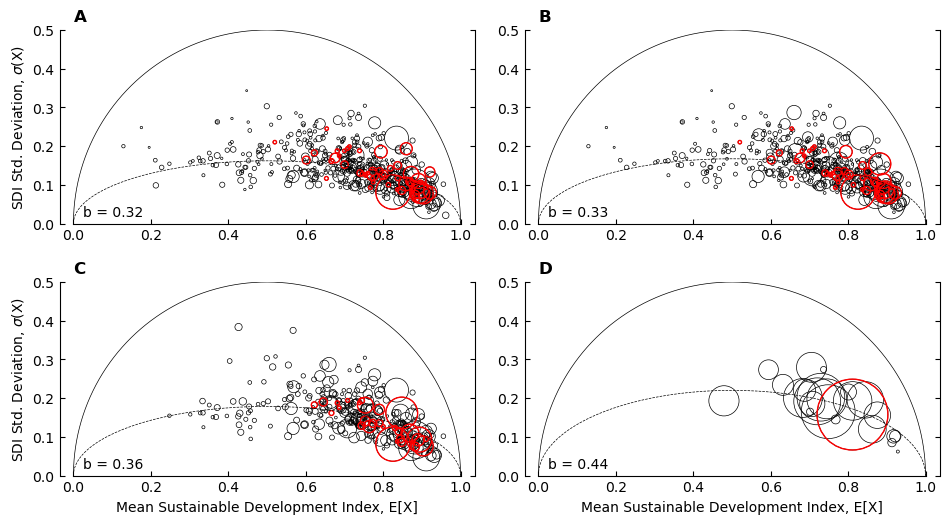

In [7]:
statecode = states[states['gmean_mean']==np.min(states['gmean_mean'].values)]['state code'].values[0]
statecode = states[states['population']==np.max(states['population'].values)]['state code'].values[0]

fig, axs = plt.subplots(2, 2, **{'figsize':(11,6)})

i=0
label='ABCD'
for boundary in [cities, subdistricts, districts, states]:

    b = b_fit(boundary, 'gmean', False)
    het_plot(boundary, b, 'gmean', cfit='k', ax=axs.flatten()[i])


    axs.flatten()[i].scatter(boundary[boundary['state code']==statecode]['gmean_mean'], boundary[boundary['state code']==statecode]['gmean_std'], s = boundary[boundary['state code']==statecode]['population']/15000, facecolors='none'
                , edgecolors='red', linewidths = 1)
    axs.flatten()[i].annotate('b = '+str(np.round(np.mean(b.bestfitplot/b.x),2)), (0.025,0.02))
    
    sns.despine(fig, axs.flatten()[i], top=True, right=False, left=False, bottom=False, offset={'left':10, 'top':10, 'right':10})

    axs.flatten()[i].set_ylim(0,0.501)
    axs.flatten()[i].set_xlim(0,1.001)
    axs.flatten()[i].set_title(label[i], loc='left', fontweight="bold")
    axs.flatten()[i].tick_params(direction="in", which='both', 
                    bottom=True, top=False, left=True, right=True)

    i+=1

axs.flatten()[0].set_ylabel(r'SDI Std. Deviation, $\sigma$(X)')
axs.flatten()[2].set_ylabel(r'SDI Std. Deviation, $\sigma$(X)')
axs.flatten()[2].set_xlabel(r'Mean Sustainable Development Index, E[X]')
axs.flatten()[3].set_xlabel(r'Mean Sustainable Development Index, E[X]')

# plt.savefig('figures/F1.pdf')

c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ci1hax\miniconda3\envs\pdd\lib\site-packages\pandas\core

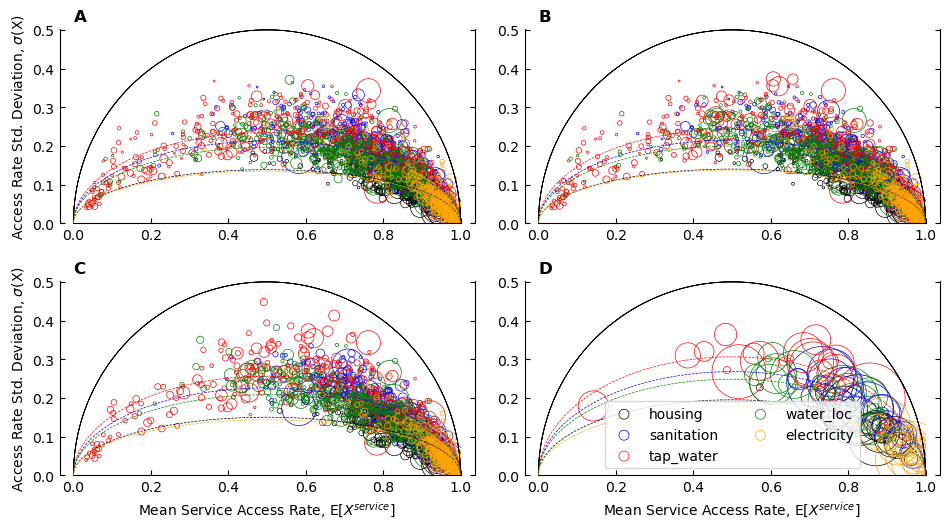

In [9]:
fig, axs = plt.subplots(2, 2, **{'figsize':(11,6)})

i=0
label='ABCD'
for boundary in [cities, subdistricts, districts, states]:

    j=0
    colors = ['black', 'blue', 'red', 'green', 'orange']
    for metric in ['housing', 'sanitation', 'tap_water', 'water_loc', 'electricity']:

        b = b_fit(boundary, metric, False)
        het_plot(boundary, b, metric,  c=colors[j], cfit=colors[j], ax=axs.flatten()[i])


        # axs.flatten()[i].scatter(boundary[boundary['state code']==statecode]['gmean_mean'], boundary[boundary['state code']==statecode]['gmean_std'], s = boundary[boundary['state code']==statecode]['population']/15000, facecolors='none'
        #             , edgecolors='gold', linewidths = 1)
        # axs.flatten()[i].annotate('b = '+str(np.round(np.mean(b.bestfitplot/b.x),2)), (0.025,0.02))
        
        j+=1

    sns.despine(fig, axs.flatten()[i], top=True, right=False, left=False, bottom=False, offset={'left':10, 'top':10, 'right':10})

    axs.flatten()[i].set_ylim(0,0.501)
    axs.flatten()[i].set_xlim(0,1.001)
    axs.flatten()[i].set_title(label[i], loc='left', fontweight="bold")
    axs.flatten()[i].tick_params(direction="in", which='both', 
                    bottom=True, top=False, left=True, right=True)

    i+=1

axs.flatten()[0].set_ylabel(r'Access Rate Std. Deviation, $\sigma$(X)')
axs.flatten()[2].set_ylabel(r'Access Rate Std. Deviation, $\sigma$(X)')
axs.flatten()[2].set_xlabel(r'Mean Service Access Rate, E[$X^{service}$]')
axs.flatten()[3].set_xlabel(r'Mean Service Access Rate, E[$X^{service}$]')

axs.flatten()[3].legend(ncols=2, markerscale=0.2)

plt.savefig('figures/F2.pdf')

# Material v SDI

In [10]:
matstates = pd.read_csv('data/Materials_vs_SDI_states.csv')
matstates.drop(columns = 'Unnamed: 0', inplace = True)
matstates.dropna(inplace = True)
matstates.head()

state code  BrickConc  BrickMetal  BrickStoneSlate  BrickBrick  \
0           1  35.037142   45.559711         0.628588    0.202748   
1           2  31.502061   53.038594         0.812381    0.472483   
2           3  69.379342    1.044848         0.751091    9.983984   
3           4  77.449726    7.483731         0.549836    1.728124   
4           5  56.227442    7.654872         1.249556   20.635243   

   Total households  StoneConc  ConcConc     gmean     amean   housing  \
0            294947   0.228516  2.911371  0.816064  0.822201  0.857235   
1             41483   0.843719  0.474893  0.911264  0.912451  0.923589   
2           1257504   0.591251  6.259543  0.873177  0.881493  0.923489   
3            214973   0.382374  4.344266  0.918674  0.919800  0.941000   
4            270416   1.052453  3.777143  0.883062  0.887261  0.933657   

   treated tap water  water location within  electricity  sanitation  
0           0.709153               0.848477     0.980499    0.715640  
1           0.932996               0.846620     0.981257    0.877790  
2           0.659886               0.926692     0.983390    0.914008  
3           0.938000               0.862000     0.984000    0.874000  
4           0.729262               0.886797     0.965166    0.921420

In [11]:
matdistricts = pd.read_csv('data/Materials_vs_SDI_districts.csv')
matdistricts.drop(columns = 'Unnamed: 0', inplace = True)
matdistricts.dropna(inplace = True)
matdistricts.head()

state code  district code  BrickConc  BrickMetal  BrickStoneSlate  \
0           1              2   8.319949   68.486990         0.256987   
1           1             10   3.688925   74.671042         0.784401   
2           1             14   7.798843   61.947556         1.304937   
3           1             15   0.000000   59.701493        10.447761   
4           1             21  83.640107    1.749045         0.318405   

   BrickBrick  Total households  StoneConc  ConcConc  population     gmean  \
0    0.064247              3113   0.000000  0.096370       97912  0.746212   
1    0.126797            160887   0.041644  0.787509     1219516  0.870044   
2    0.067709             16246   0.024621  1.114120      282887  0.646169   
3    0.000000                67   0.000000  0.000000       80613  0.441065   
4    0.332362            114634   0.526022  6.225029      765013  0.883196   

    amean  housing  treated tap water  water location within  electricity  \
0  0.7610    0.879              0.581                  0.744        0.979   
1  0.8746    0.879              0.828                  0.942        0.988   
2  0.6790    0.766              0.386                  0.764        0.959   
3  0.5378    0.698              0.115                  0.533        0.918   
4  0.8862    0.931              0.805                  0.904        0.989   

   sanitation  
0       0.622  
1       0.736  
2       0.520  
3       0.425  
4       0.802

In [12]:
matsubdistricts = pd.read_csv('data/Materials_vs_SDI_tehsils.csv')
matsubdistricts.drop(columns = 'Unnamed: 0', inplace = True)
matsubdistricts.dropna(inplace = True)
matsubdistricts.head()

state code  district code  tehsil code  BrickConc  BrickMetal  \
0           1              2            8   8.319949   68.486990   
1           1             10           43   3.712397   74.555276   
2           1             10           44   0.355556   91.111111   
3           1             14           55   7.798843   61.947556   
4           1             15           59   0.000000   59.701493   

   BrickStoneSlate  BrickBrick  Total households  StoneConc  ConcConc  \
0         0.256987    0.064247              3113   0.000000  0.096370   
1         0.786795    0.127690            159762   0.041937  0.793055   
2         0.444444    0.000000              1125   0.000000  0.000000   
3         1.304937    0.067709             16246   0.024621  1.114120   
4        10.447761    0.000000                67   0.000000  0.000000   

      gmean   amean  housing  treated tap water  sanitation  \
0  0.756842  0.7744    0.892              0.514       0.736   
1  0.869148  0.8738    0.877              0.827       0.734   
2  0.942821  0.9444    0.973              0.847       0.975   
3  0.683058  0.7112    0.790              0.452       0.527   
4  0.459207  0.5574    0.718              0.122       0.438   

   water location within  electricity  
0                  0.754        0.976  
1                  0.943        0.988  
2                  0.929        0.998  
3                  0.803        0.984  
4                  0.562        0.947

In [13]:
matcities = pd.read_csv('data/Materials_vs_SDI_cities.csv')
matcities.drop(columns = 'Unnamed: 0', inplace = True)
matcities.dropna(inplace = True)
matcities.head()

state code  district code  tehsil code  town village code  BrickConc  \
0          35            640         5923             804041   2.181674   
1          28            532         4306             802896  37.476311   
2          28            533         4368             802904  42.425149   
3          28            534         4399             802907  23.694534   
4          28            534         4400             802907   6.440198   

   BrickMetal  BrickStoneSlate  BrickBrick     gmean   amean  StoneConc  \
0    2.443475         0.003967    0.007933  0.892876  0.8968   0.404601   
1    5.081333         0.963361    0.075016  0.706051  0.7166   7.477890   
2   11.406042         0.866338    0.377059  0.767060  0.7776  15.692846   
3   42.839718         0.514274    0.052746  0.824529  0.8302   6.964133   
4   34.324133         0.707714    0.424628  0.537716  0.5908   1.556971   

    ConcConc                   Area Name  households  population  \
0  21.543038           Port Blair (M Cl)       27049      108058   
1   2.143872                Adilabad (M)       25840      117167   
2   2.651385         Nizamabad (M Corp.)       66617      311152   
3   0.194501  Ramagundam (M + OG) (Part)       59244      237559   
4   0.000000  Ramagundam (M + OG) (Part)        1430        5420   

   Total households  OtherOther  
0             25210   73.415311  
1             25328   46.782217  
2             66833   26.581180  
3             60668   25.740094  
4              1413   56.546355

# Plots

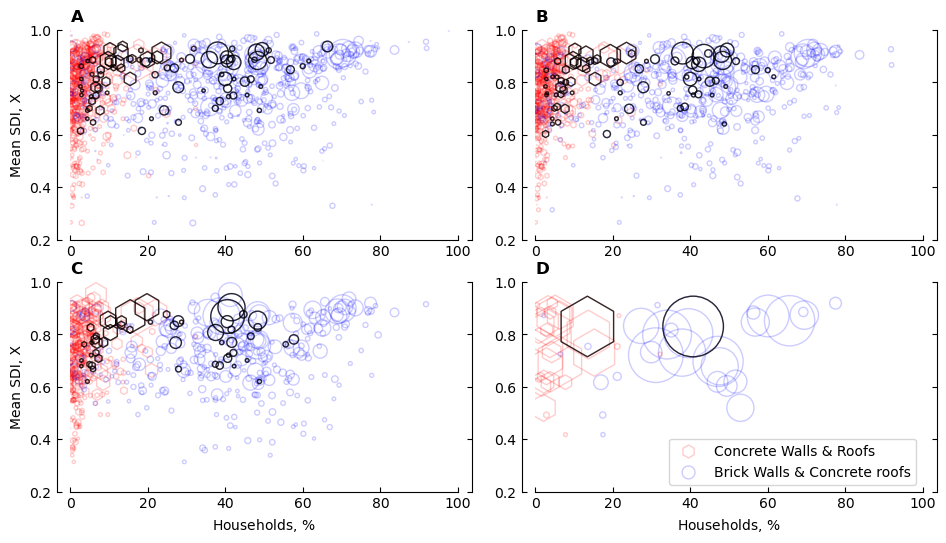

In [14]:
statecode = matstates[matstates['gmean']==np.min(matstates['gmean'].values)]['state code'].values[0]
statecode = matstates[matstates['Total households']==np.max(matstates['Total households'].values)]['state code'].values[0]

fig, axs = plt.subplots(2, 2, **{'figsize':(11,6)})

i=0
label='ABCD'
for df in [matcities, matsubdistricts, matdistricts, matstates]:

    axs.flatten()[i].scatter(x = df['ConcConc'], y = df['gmean'], label = r'Concrete Walls & Roofs', edgecolor = 'red', marker='h', facecolor='none', alpha = 0.2, s = df['Total households']/3000)
    axs.flatten()[i].scatter(x = df['BrickConc'], y = df['gmean'], label = r'Brick Walls & Concrete roofs', edgecolor = 'blue', facecolor='none', alpha = 0.2, s = df['Total households']/3000)

    axs.flatten()[i].scatter(x = df[df['state code']==statecode]['ConcConc'], y = df[df['state code']==statecode]['gmean'], 
                             edgecolor = 'black', marker='h',  facecolor='none', alpha = 0.8, s = df[df['state code']==statecode]['Total households']/3000)
    axs.flatten()[i].scatter(x = df[df['state code']==statecode]['BrickConc'], y = df[df['state code']==statecode]['gmean'], 
                             edgecolor = 'black', facecolor='none', alpha = 0.8, s = df[df['state code']==statecode]['Total households']/3000)
    
    sns.despine(fig, axs.flatten()[i], top=True, right=False, left=False, bottom=False, offset={'left':10, 'top':10, 'right':10})

    axs.flatten()[i].set_ylim(0.2,1.001)
    axs.flatten()[i].set_xlim(0,100.001)
    axs.flatten()[i].set_title(label[i], loc='left', fontweight="bold")
    axs.flatten()[i].tick_params(direction="in", which='both', 
                    bottom=True, top=False, left=True, right=True)

    i+=1

axs.flatten()[0].set_ylabel(r'Mean SDI, X')
axs.flatten()[2].set_ylabel(r'Mean SDI, X')
axs.flatten()[2].set_xlabel(r'Households, $\%$')
axs.flatten()[3].set_xlabel(r'Households, $\%$')

axs.flatten()[3].legend(ncols=1, markerscale=0.3, loc=4)

plt.savefig('figures/F3.pdf')

# projections

In [15]:
ward_sdi = cities.copy()
# ward_sdi = pd.read_csv('data/SDI_wards.csv')
# ward_sdi = ward_sdi[ward_sdi['housing'] <= 1]

# ward_sdi.drop(columns = 'Unnamed: 0', inplace = True)
# ward_sdi.dropna(inplace = True)

ward_sdi['housing_mean'] = ward_sdi['housing_mean']*ward_sdi['households']
ward_sdi['sanitation_mean'] = ward_sdi['sanitation_mean']*ward_sdi['households']
ward_sdi['tap_water_mean'] = ward_sdi['tap_water_mean']*ward_sdi['households']
ward_sdi['water_loc_mean'] = ward_sdi['water_loc_mean']*ward_sdi['households']
ward_sdi['electricity_mean'] = ward_sdi['electricity_mean']*ward_sdi['households']
ward_sdi= ward_sdi.rename(columns = {'housing_mean':'housing', 'sanitation_mean':'sanitation', 'tap_water_mean':'tap_water', 'water_loc_mean':'water_loc', 'electricity_mean':'electricity'})


# ward_sdi= ward_sdi.rename(columns = {'housing':'housing', 'sanitation':'sanitation', 'treated tap water':'tap_water', 'water location within':'water_loc', 'electricity':'electricity'})
# ward_sdi['housing'] = ward_sdi['housing']*ward_sdi['households']
# ward_sdi['sanitation'] = ward_sdi['sanitation']*ward_sdi['households']
# ward_sdi['tap_water'] = ward_sdi['tap_water']*ward_sdi['households']
# ward_sdi['water_loc'] = ward_sdi['water_loc']*ward_sdi['households']
# ward_sdi['electricity'] = ward_sdi['electricity']*ward_sdi['households']

ward_sdi = ward_sdi.groupby(['state code', 'district code', 'tehsil code' , 'town village code'], as_index=False).sum()
ward_sdi  = ward_sdi.reset_index()
ward_sdi.sort_values('housing').tail()



index  state code  district code  tehsil code  town village code  \
186    186          19            342        99999             801742   
446    446          33            603        99999             803339   
264    264          24            474         3781             802484   
301    301          27            518        99999             802794   
384    384          29            572        99999             803162   

     population  households       housing    sanitation     tap_water  ...  \
186     4496694     1024928  9.604811e+05  9.649806e+05  9.009117e+05  ...   
446     4646732     1154982  1.086764e+06  1.086257e+06  9.052153e+05  ...   
264     5577940     1179823  1.118824e+06  1.084175e+06  9.640810e+05  ...   
301     9171390     2067347  1.951249e+06  1.204393e+06  1.949835e+06  ...   
384     8443675     2101831  1.978991e+06  2.018766e+06  1.604610e+06  ...   

     water_loc_std  electricity_std  gmean_std  amean std  bernoulli_gmean  \
186       0.150955         0.031322   0.075175   0.064263         0.315560   
446       0.173952         0.017692   0.070154   0.059282         0.334179   
264       0.054010         0.011009   0.046631   0.040435         0.284060   
301       0.120695         0.021321   0.081410   0.067622         0.379554   
384       0.146002         0.014551   0.098331   0.078075         0.321705   

     bernoulli_tap_water  bernoulli_water_loc  bernoulli_housing  \
186             0.326127             0.428465           0.242746   
446             0.411688             0.429685           0.235745   
264             0.386551             0.280209           0.221424   
301             0.231541             0.407246           0.230226   
384             0.424973             0.374252           0.234582   

     bernoulli_sanitation  bernoulli_electricity  
186              0.234666               0.189040  
446              0.236564               0.102409  
264              0.272943               0.121482  
301              0.493134               0.167066  
384              0.194829               0.125631  

[5 rows x 27 columns]

In [16]:
scale = pd.read_csv('data/material_coefficients.csv')


In [17]:
matsen1 = matstates.copy()
matsen1['housing']=matsen1['Total households']*(100-(matsen1['BrickConc']+matsen1['ConcConc']))/100
matsen1=matsen1.rename(columns={'Total households':'households'})

matsen2 = matstates.copy()
matsen2['housing']=matsen2['Total households']*(100-(matsen2['BrickMetal']+matsen2['BrickConc']+matsen2['ConcConc']+matsen2['BrickBrick']+matsen2['StoneConc']))/100
matsen2=matsen2.rename(columns={'Total households':'households'})

C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\2987947414.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.flatten()[i].set_xticklabels(labels)
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\2987947414.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.flatten()[i].set_xticklabels(labels)
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\2987947414.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.flatten()[i].set_xticklabels(labels)
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\2987947414.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.flatten()[i].set_xticklabels(labels)
C:\Users\ci1hax\AppData\Local\Temp\ipyke

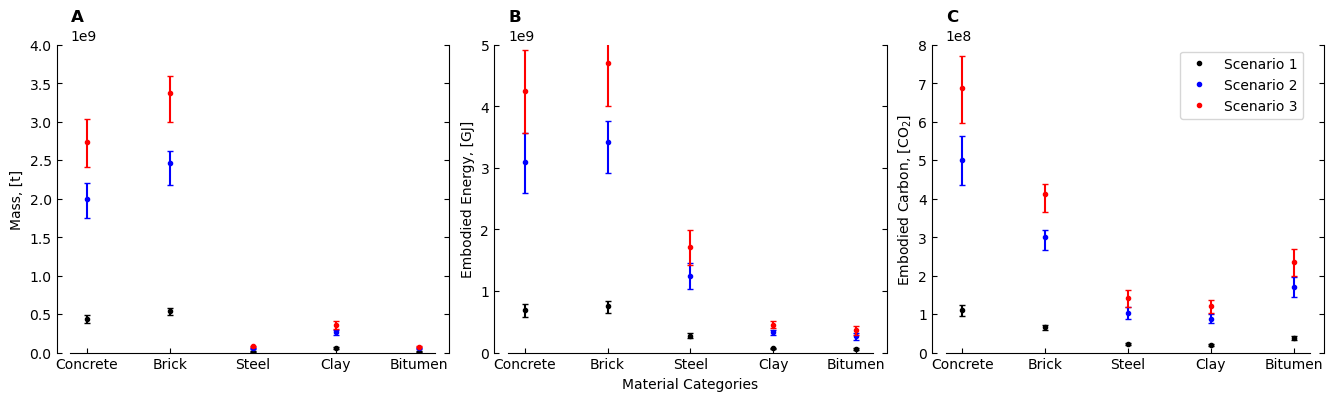

In [19]:
fig, axs = plt.subplots(1, 3, **{'figsize':(16,4)})

leg = ['Scenario 1', 'Scenario 2', 'Scenario 3']
labels = ['Concrete', 'Brick', 'Steel', 'Clay', 'Bitumen']
j=0
for df in [ward_sdi[['housing', 'sanitation', 'tap_water', 'water_loc', 'electricity' ,'households', 'population']].copy(), 
           matsen1, 
           matsen2]:
    projection_min = proj_material(df, scale, 'Min')
    projection_mean = proj_material(df, scale, 'Average')
    projection_max = proj_material(df, scale, 'Max')

    for i in range(0,3):
            axs.flatten()[i].plot(labels, projection_mean[i+1].values[0], marker='.', ls='', color=colors[j], label=leg[j])
            axs.flatten()[i].errorbar(labels, projection_mean[i+1].values[0],
                                      np.append((projection_mean[i+1].values-projection_min[i+1].values),
                                            (projection_max[i+1].values-projection_mean[i+1].values), 0),
                                    fmt='none', color=colors[j], capsize=2)
            
            base = np.max(projection_max[i+1].values)
            order = int(np.max(np.log10(projection_max[i+1].values)))
            
            axs.flatten()[i].set_ylim(0, np.round(base/(10**order),0)*(10**order))
            axs.flatten()[i].set_xticklabels(labels)
            axs.flatten()[i].set_title(label[i], loc='left', fontweight="bold")
            axs.flatten()[i].tick_params(direction="in", which='both',   
                                    bottom=True, top=False, left=True, right=True)
            sns.despine(fig, axs.flatten()[i], top=True, right=False, left=False, bottom=False, offset={'left':10, 'top':10, 'right':10})

    j+=1

axs.flatten()[0].set_ylabel(r'Mass, [t]')
axs.flatten()[1].set_ylabel(r'Embodied Energy, [GJ]')
axs.flatten()[2].set_ylabel(r'Embodied Carbon, [CO$_2$]')
axs.flatten()[1].set_xlabel(r'Material Categories')
axs.flatten()[2].legend(ncols=1, loc=1)

plt.savefig('figures/F4A.pdf')

C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\2869966104.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs.scatter(x=x, y=y,
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\2869966104.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs.scatter(x=x, y=y,
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\2869966104.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs.scatter(x=x, y=y,


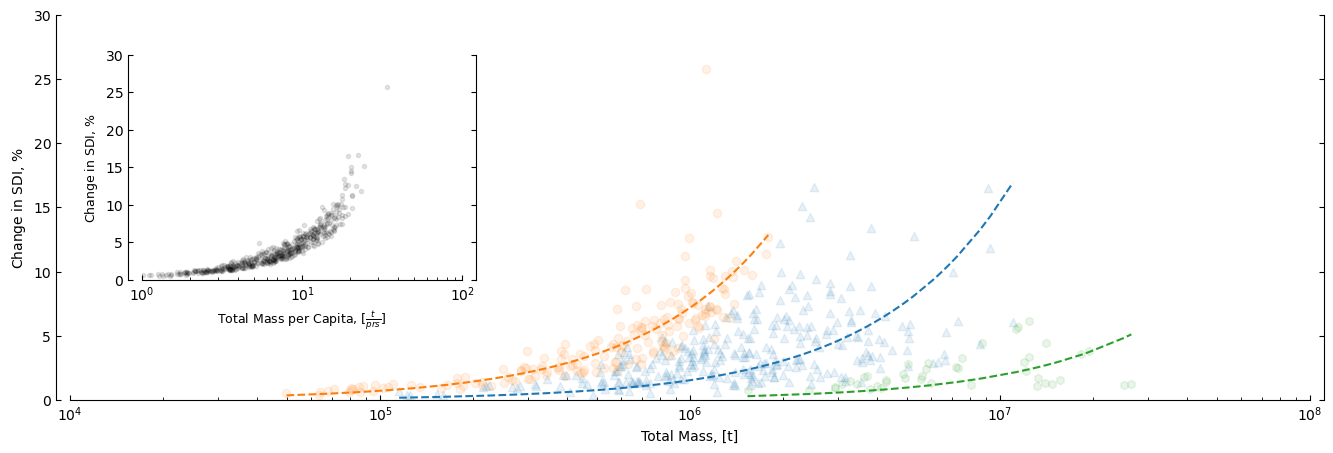

In [20]:
statecode = matstates[matstates['gmean']==np.min(matstates['gmean'].values)]['state code'].values[0]
statecode = matstates[matstates['Total households']==np.max(matstates['Total households'].values)]['state code'].values[0]

fig, axs = plt.subplots(1, 1, **{'figsize':(16,5)})

left, bottom, width, height = [0.17, 0.35, 0.20, 0.45]
axs2 = fig.add_axes([left, bottom, width, height])

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ca0020","#f4a582","#000000", "#92c5de", "#0571b0"], 3)

leg = []
labels = []
i=0
isize=['o', '^', 'h']
projection_mean = sdi_proj(ward_sdi.copy(), scale, 'Average')
for size in [1,0,2]: 

        x = projection_mean[(np.log10(projection_mean['population'])<size+5)&(np.log10(projection_mean['population'])>=size+4)]['Total mass']
        y = projection_mean[(np.log10(projection_mean['population'])<size+5)&(np.log10(projection_mean['population'])>=size+4)]['gmean diff_2']
        lfit = sm.OLS(y, x).fit()
        
        axs.scatter(x=x, y=y,
                    marker = isize[size],
                #     c = [size for x in range(len(x))], facecolor='none', 
                alpha = 0.1, cmap=cmap, vmin=0, vmax=3)
        axs.plot(np.sort(x), [k*lfit.params for k in np.sort(x)], '--')

x = projection_mean['Total mass']
x = x / projection_mean['population']
y = projection_mean['gmean diff_2']
lfit = sm.OLS(y, x).fit()

axs2.plot(x, y, 'k.',
            alpha = 0.1)
# axs2.plot(np.sort(x), [k*lfit.params for k in np.sort(x)], 'k--')

axs.set_xscale('log')
axs2.set_xscale('log')


# axs.set_title(label[i], loc='left', fontweight="bold")
axs.tick_params(direction="in", which='both',   
                                bottom=True, top=False, left=True, right=True)
axs2.tick_params(direction="in", which='both',   
                                bottom=True, top=False, left=True, right=True)
sns.despine(fig, axs, top=True, right=False, left=False, bottom=False, offset={'left':10, 'top':10, 'right':10})
sns.despine(fig, axs2, top=True, right=False, left=False, bottom=False, offset={'left':10, 'top':10, 'right':10})

axs.set_ylim(0,30)
# axs[0].set_ylim(0,0.12)
axs.set_xlim(10000,100000000)
# axs[0].set_xlim(0,35)

axs2.set_ylim(0,30)
# axs[1].set_ylim(0,0.10)
# axs[1].set_xlim(0,2.5)
axs2.set_xlim(1,100)


axs.set_ylabel(r'Change in SDI, $\%$')
axs.set_xlabel(r'Total Mass, [t]')

axs2.set_ylabel(r'Change in SDI, $\%$', fontsize=9)
axs2.set_xlabel(r'Total Mass per Capita, [$\frac{t}{prs}$]', fontsize=9)

plt.savefig('figures/F4B.pdf')

In [21]:
sdi = pd.read_csv('./data/SDI_wards.csv')
sdi.drop(columns = 'Unnamed: 0', inplace = True)
sdi = sdi[['state code', 'district code', 'tehsil code', 'town village code', 'population', 'households', 'gmean', 'amean']]

C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\3294158037.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mat_mean = mat_mean.append(mean)
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\3294158037.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mat_mean = mat_mean.append(mean)
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\3294158037.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mat_mean = mat_mean.append(mean)
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\3294158037.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mat_mean = mat_mean.append(mean)
C:\Users\ci1hax\AppData\Local\Temp\ipykernel_35700\3

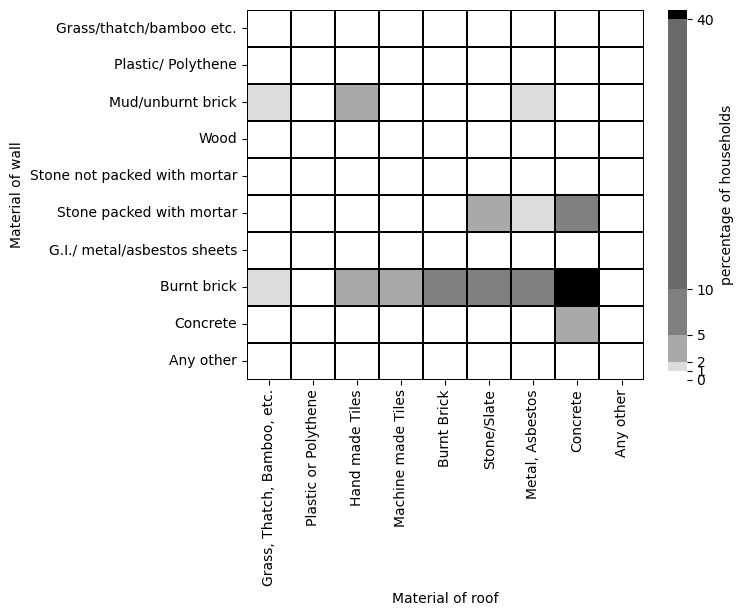

In [23]:
from matplotlib import colors

# Get the base colormap
newcolors = plt.get_cmap('viridis', 41).colors.copy()  # Use .copy() to avoid modifying the original

# Assign new colors of interest
newcolors[:1, :] = colors.to_rgba('white')
newcolors[1:2, :] = colors.to_rgba('gainsboro')
newcolors[2:5, :] = colors.to_rgba('darkgray')
newcolors[5:10, :] = colors.to_rgba('gray')
newcolors[10:40, :] = colors.to_rgba('dimgray')
newcolors[40:41, :] = colors.to_rgba('black')

# Create the customized color map
cmap = colors.ListedColormap(newcolors)

mat = pd.read_csv('./data/census_housing_3.csv')
mat.rename(columns = {'State Code':'state code', 'District Code':'district code', 'Tehsil Code':'tehsil code'
                     , 'Town Code':'town village code'}, inplace =True)

mat = mat[(mat['town village code'] !=0) & (mat['district code'] !=0) & (mat['tehsil code'] !=0)]
mat = mat[mat['Area type'] == 'Urban']
merge = mat.merge(sdi, on = ['state code', 'district code', 'tehsil code', 'town village code'])

city_mat_total = merge[merge['Material of wall'] == 'All Material']
city_mat_total = city_mat_total[['state code', 'district code', 'tehsil code', 'town village code', 'Total number of households']]
city_mat_total = city_mat_total.rename(columns = {'Total number of households':'Total households'})

merge = merge.merge(city_mat_total, how = 'left', on =['state code', 'district code', 'tehsil code', 'town village code'])
merge.drop(columns = ['Area type'], inplace = True)

columns_titles = ['state code', 'district code', 'tehsil code', 'town village code', 'Area Name',
    'Material of wall',
       'Total number of households', 'Grass/Thatch/Bamboo/Wood/Mud etc.',
       'Plastic/ Polythene', 'Hand made Tiles', 'Machine made Tiles',
       'Burnt Brick', 'Stone/Slate', 'G.I./Metal/Asbestos sheets', 'Concrete',
       'Any other', 'households', 'population', 'gmean', 'amean', 'Total households']
merge=merge.reindex(columns=columns_titles)
# merge.iloc[:,7:16] = merge.iloc[:,7:16].apply(pd.to_numeric)
merge.iloc[:,7:16] = merge.iloc[:,7:16].div(merge["Total households"].values, axis = 0)*100

wallmat = merge['Material of wall'].unique()

i = 0
mat_mean = pd.DataFrame()

while i <= len(wallmat) -1:
    mean = merge[merge['Material of wall'] == wallmat[i]].drop(columns = ['state code', 'district code'
                                                                                                      , 'tehsil code', 'town village code'
                                                                                                      , 'Total number of households'
                                                                                                , 'households'
                                                                                                , 'population'
                                                                                                 , 'gmean'
                                                                                                 , 'amean'])
    mean = mean.describe().loc[['mean']]
    mean.rename(index = {'mean':wallmat[i]}, inplace = True)
    mat_mean = mat_mean.append(mean)
    i+=1
    
mat_mean.drop(columns = 'Total households')
mat_mean = mat_mean.reset_index().rename(columns = {'index':'Material of wall'})
mat_mean.drop(columns = 'Total households', inplace = True)
mat_mean

hmap = mat_mean.iloc[1: , :]
hmap = hmap.set_index('Material of wall')

hmap = hmap.rename(columns ={'Grass/Thatch/Bamboo/Wood/Mud etc.':'Grass, Thatch, Bamboo, etc.', 
                             'G.I./Metal/Asbestos sheets':'Metal, Asbestos',
                              'Plastic/ Polythene': 'Plastic or Polythene'})

hmap = sns.heatmap(data = hmap, cbar_kws={'label': 'percentage of households', 'ticks':[0,1,2,5,10,40,100]}, 
                  linewidths=0.1, linecolor='black', cmap=cmap, vmin = 0, vmax = 41)
#hmap.set_title('Mean composition of housing within the towns/cities of India (%)')
plt.xlabel('Material of roof')
plt.ylabel('Material of wall')
#plt.xlabel(fontsize=16)
figure = hmap.get_figure()    

plt.savefig('figures/F5.pdf')